<a href="https://colab.research.google.com/github/GeekAlexis/CS165B-Fashion-MNIST-dataset/blob/master/Fashion_MNIST_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Fashion-MNIST Convolutional Neural Network (CS 165B)

##Set up TPU environment

In [0]:
import os
import pprint
import tensorflow as tf

if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.28.59.250:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 6236997416312189630),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16887947366780463142),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14695492728402413758),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 767876541387888416),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 823758408819109757),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 944385295483498241),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 11295615282333891687),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 891362139587923672),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 53501517284023738

##Clone image dataset

In [0]:
!git clone https://github.com/GeekAlexis/CS165B-Fashion-MNIST-dataset.git
%cd CS165B-Fashion-MNIST-dataset/

Cloning into 'CS165B-Fashion-MNIST-dataset'...
remote: Enumerating objects: 60419, done.
remote: Counting objects: 100% (60419/60419), done.
remote: Compressing objects: 100% (60417/60417), done.
remote: Total 60419 (delta 0), reused 60416 (delta 0), pack-reused 0
Receiving objects: 100% (60419/60419), 31.05 MiB | 21.75 MiB/s, done.
Checking out files: 100% (60403/60403), done.
/content/CS165B-Fashion-MNIST-dataset


## Load and preprocess images

In [0]:
import os
import math
import pprint
import numpy as np
import cv2
from collections import Counter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

classes = [
  'T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'
]

val_split = False 
class_weight = None

aug_params = {
    'rotation_range':         5,         # randomly rotate images in the range (degrees, 0 to 180)
    'width_shift_range':      0.1,        # randomly shift images horizontally (fraction of total width)
    'height_shift_range':     0.1,        # randomly shift images vertically (fraction of total height)
    'shear_range':            0.,         # set range for random shear
    'zoom_range':             0.1,        # set range for random zoom
    'fill_mode':              'constant',  # set mode for filling points outside the input boundaries
    'cval':                   0.,         # value used for fill_mode = "constant"
    'horizontal_flip':        True,       # randomly flip images
    'vertical_flip':          False,      # randomly flip images
    'rescale':                None,       # set rescaling factor (applied before any other transformation)
    'preprocessing_function': None,       # set function that will be applied on each input
}

img_gen = ImageDataGenerator(**aug_params)

def load_train_data():
  X, y = [], []
  train_data_dir = os.path.join(os.getcwd(), 'hw4_train')
  for label in range(len(classes)):
    label_dir = os.path.join(train_data_dir, str(label))
    for img_name in os.listdir(label_dir):
      img = cv2.imread(os.path.join(label_dir, img_name), 0).reshape(28, 28, 1)
      X.append(img)
      y.append(label)
  X, y = np.array(X, dtype='float32'), np.array(y)
  return X, y

def normalize(X_train, X_test):
#   X_train = X_train / 255
#   X_test = X_test / 255
  mu = np.mean(X_train, axis=0)
  std = np.std(X_train, axis=0)
  X_train = (X_train - mu) / std
  X_test = (X_test - mu) / std
  return X_train, X_test

def expand_data(X, y, factor=2):
  for i, (X_batch, y_batch) in enumerate(img_gen.flow(X, y, batch_size=len(X))):
    if i >= factor - 1:
      break
    X, y = np.concatenate((X, X_batch)), np.concatenate((y, y_batch))
  return X, y

def get_class_weight(y):
  class_freq = Counter(y)
  return {label: math.log(len(y) / class_freq[label]) for label in range(len(classes))}
    
def even_out_dist(X, y, max_freq=None):
  class_freq = Counter(y)
  if max_freq is None:
    max_freq = max(class_freq.values())
  class_data = [[] for i in range(len(classes))]
  for i, label in enumerate(y):
    class_data[label].append(X[i])
  for c in range(len(classes)):
    if max_freq < class_freq[c]:
      raise ValueError("max_freq must be greater than any class frequency")
    print('Expanding class {} from {} to {}'.format(c, class_freq[c], max_freq))
    num = len(class_data[c])
    for X_batch in img_gen.flow(np.array(class_data[c]), batch_size=class_freq[c], shuffle=True):
      num += len(X_batch)
      if num >= max_freq:
        if num - len(X_batch) < max_freq:
          X = np.concatenate((X, X_batch[:max_freq - (num - len(X_batch))]))
          y = np.append(y, [c]*(max_freq - (num - len(X_batch))))
        break
      X, y = np.concatenate((X, X_batch)), np.append(y, [c]*len(X_batch))
  return X, y
  
X_train, y_train = load_train_data()
if val_split:
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)
class_weight = get_class_weight(y_train)
print('class weight:')
pprint.pprint(class_weight)

X_train, y_train = even_out_dist(X_train, y_train, max_freq=40000)
# X_train, y_train = expand_data(X_train, y_train, factor=2)
print('training data size:', X_train.shape[0])
if val_split:
  print('validation data size:', X_val.shape[0])

class weight:
{0: 2.2152430828388976,
 1: 2.128231705849268,
 2: 2.559014621941722,
 3: 2.128231705849268,
 4: 2.3105532626432224,
 5: 2.128231705849268,
 6: 2.4849066497880004,
 7: 2.3513752571634776,
 8: 2.128231705849268,
 9: 2.8213788864092133}
Expanding class 0 from 5500 to 40000
Expanding class 1 from 6000 to 40000
Expanding class 2 from 3900 to 40000
Expanding class 3 from 6000 to 40000
Expanding class 4 from 5000 to 40000
Expanding class 5 from 6000 to 40000
Expanding class 6 from 4200 to 40000
Expanding class 7 from 4800 to 40000
Expanding class 8 from 6000 to 40000
Expanding class 9 from 3000 to 40000
training data size: 400000


## Data visualization

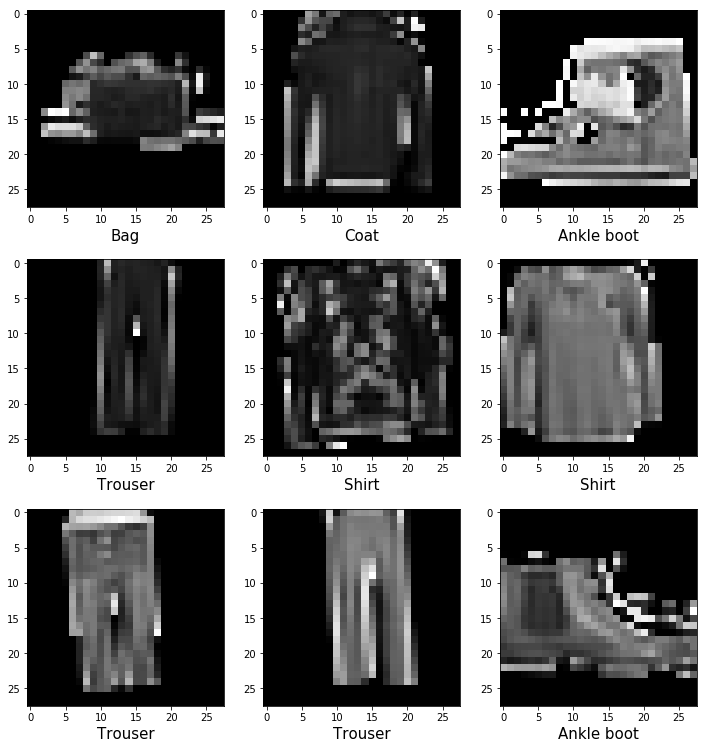

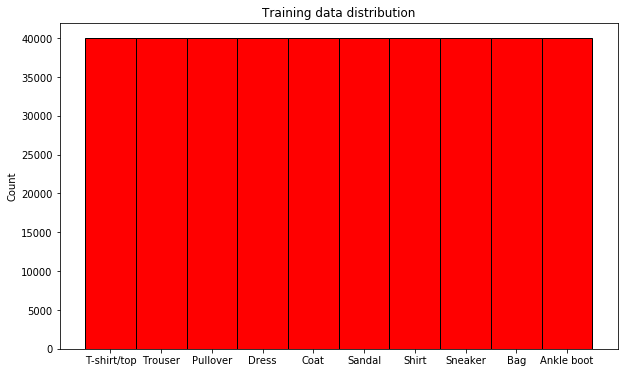

In [0]:
import matplotlib.pyplot as plt
import random
fig, axes = plt.subplots(3, 3, figsize=(12, 13))
for row in axes:
  for axis in row:
    rand_idx = random.randrange(len(X_train))
    axis.set_xlabel(classes[y_train[rand_idx]], fontsize=15)
    axis.imshow(X_train[rand_idx].reshape(28, 28), cmap='gray')

fig = plt.figure()
fig.set_size_inches(10, 6)
plt.hist(y_train, bins=np.arange(11) - 0.5, facecolor='red', edgecolor='black')
plt.xticks(np.arange(10), [classes[i] for i in range(10)])
plt.ylabel('Count')
plt.title("Training data distribution")
plt.show()

In [0]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(classes))
if val_split:
  y_val = tf.keras.utils.to_categorical(y_val, num_classes=len(classes))

## CNN model

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam

save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
  os.makedirs(save_dir)
model_name = 'fashion_mnist_cnn0.h5'
model_path = os.path.join(save_dir, model_name)

model = Sequential()

model.add(BatchNormalization(input_shape=X_train.shape[1:]))
model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=None))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5, 5), padding='same', kernel_regularizer=None))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=None))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', kernel_regularizer=None))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, kernel_regularizer=None))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(512, kernel_regularizer=None))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(Activation('softmax'))

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    )
)

# sgd = SGD(lr=0.03, decay=1e-6, momentum=0.9, nesterov=True)
# tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08)

tpu_model.compile(
    optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=1e-8),
    loss=tf.keras.losses.categorical_crossentropy,
    metrics=['acc']
)

tpu_model.summary()

INFO:tensorflow:Querying Tensorflow master (grpc://10.28.59.250:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 6236997416312189630)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 16887947366780463142)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14695492728402413758)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 767876541387888416)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 823758408819109757)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/j

## Train CNN

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# def train_gen(batch_size):
#   while True:
#     offset = np.random.randint(0, x_train.shape[0] - batch_size)
#     yield x_train[offset:offset+batch_size], y_train[offset:offset + batch_size]

cb = [ReduceLROnPlateau(monitor='acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)]

val_cb = [
    ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=1, factor=0.5, min_lr=0.00001),
    # EarlyStopping(monitor='val_acc', patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True),
]

if val_split:
  hist = tpu_model.fit(X_train, y_train, batch_size=128*8, epochs=100, class_weight=class_weight, validation_data=(X_val, y_val), callbacks=val_cb, verbose=1)
  scores = tpu_model.evaluate(X_val, y_val)
  print('loss:', scores[0])
  print('accuracy:', scores[1])
else:
  hist = tpu_model.fit(X_train, y_train, batch_size=128*8, epochs=100, class_weight=class_weight, callbacks=cb, verbose=1)

Epoch 1/100
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(128,), dtype=tf.int32, name='core_id_60'), TensorSpec(shape=(128, 28, 28, 1), dtype=tf.float32, name='batch_normalization_v1_18_input_10'), TensorSpec(shape=(128, 10), dtype=tf.float32, name='activation_27_target_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 9.99999993922529e-09, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for batch_normalization_v1_18_input
INFO:tensorflow:KerasCrossShard: <tensorflow.python.keras.optimizers.Adam object at 0x7fe2a05702e8> []
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 33.8834912776947 secs
INFO:tensorflow:Setting weights on TPU model.
INFO:tensorflow:CPU -> TPU lr: 0.0010000000474974513 {0.001}
INFO:tensorflow:CPU -> TPU beta_1: 0.899999976158

## Training evaluation

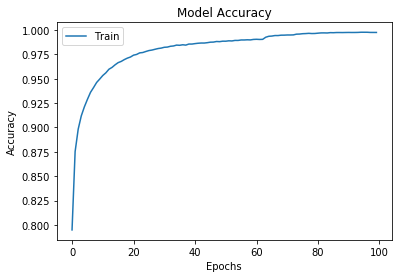

In [0]:
import matplotlib.pyplot as plt
legend = ['Train']
plt.plot(hist.history['acc'])
if val_split:
  plt.plot(hist.history['val_acc'])
  legend.append('Validation')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

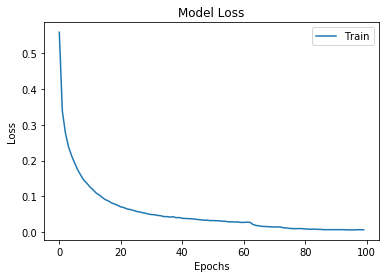

In [0]:
import matplotlib.pyplot as plt
legend = ['Train']
plt.plot(hist.history['loss'])
if val_split:
  plt.plot(hist.history['val_loss'])
  legend.append('Validation')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper right')
plt.show()

## Inference on sample test images

INFO:tensorflow:New input shapes; (re-)compiling: mode=infer (# of cores 8), [TensorSpec(shape=(1, 28, 28, 1), dtype=tf.float32, name='batch_normalization_v1_18_input_10')]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Cloning Adam {'lr': 0.0010000000474974513, 'beta_1': 0.8999999761581421, 'beta_2': 0.9990000128746033, 'decay': 9.99999993922529e-09, 'epsilon': 1e-07, 'amsgrad': False}
INFO:tensorflow:Remapping placeholder for batch_normalization_v1_18_input
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 32.591264963150024 secs
16/16 [==============================] - 48s 3s/sample


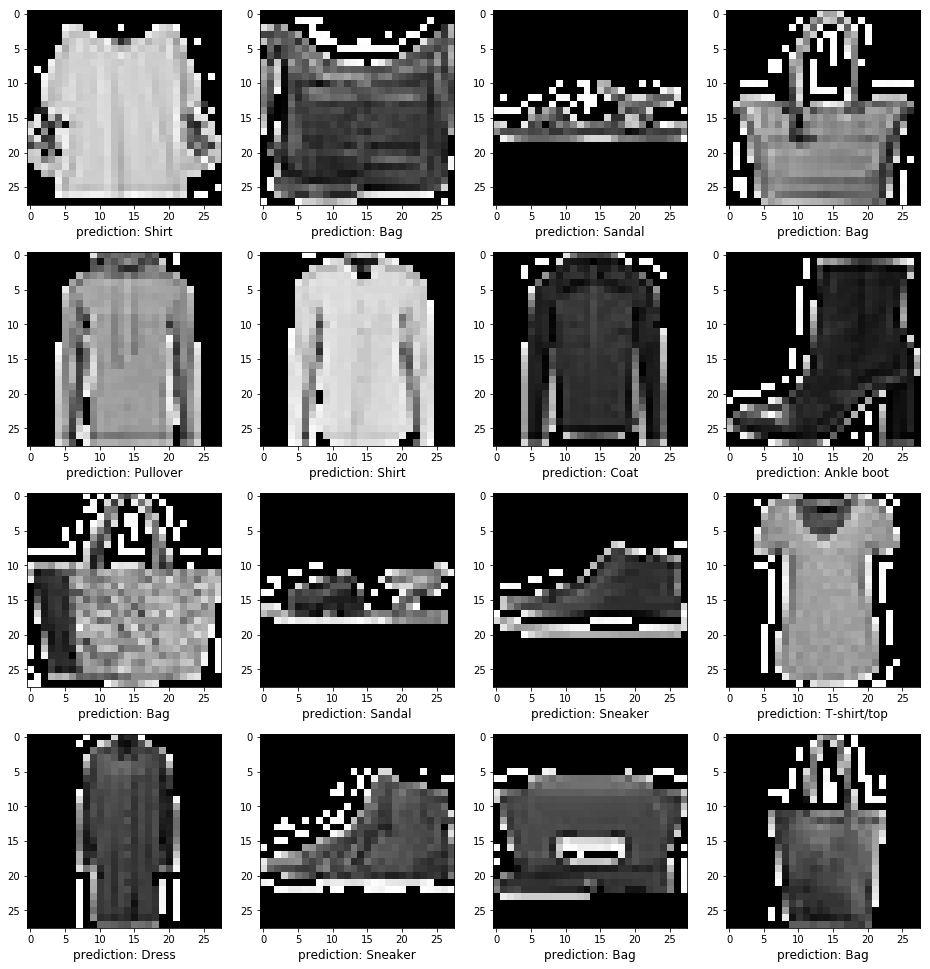

In [0]:
import matplotlib.pyplot as plt
import random

def load_sample_images(size):
  test_data_dir = os.path.join(os.getcwd(), 'hw4_test')
  imgs = [cv2.imread(os.path.join(test_data_dir, str(random.randrange(10000)) + '.png'), 0).reshape(28, 28, 1) for i in range(size)]
  return np.array(imgs, dtype='float32')

samples = load_sample_images(16)
out_layers = tpu_model.predict(samples, batch_size=8, verbose=1)
predictions = [np.argmax(layer) for layer in out_layers]

fig, axes = plt.subplots(4, 4, figsize=(16, 17))
i = 0
for row in axes:
  for axis in row:
    axis.set_xlabel('prediction: ' + classes[predictions[i]], fontsize=12)
    axis.imshow(samples[i].reshape(28, 28), cmap='gray')
    i += 1

## Download model

In [0]:
from google.colab import files

if not val_split:
  tpu_model.save(model_path)
  print('Saved trained model at', model_path)
del tpu_model
files.download(model_path) 

INFO:tensorflow:Copying TPU weights to the CPU
INFO:tensorflow:TPU -> CPU lr: 9.999999747378752e-06
INFO:tensorflow:TPU -> CPU beta_1: 0.8999999761581421
INFO:tensorflow:TPU -> CPU beta_2: 0.9990000128746033
INFO:tensorflow:TPU -> CPU decay: 9.99999993922529e-09
INFO:tensorflow:TPU -> CPU epsilon: 1e-07
INFO:tensorflow:TPU -> CPU amsgrad: False
Saved trained model at /content/CS165B-Fashion-MNIST-dataset/saved_models/fashion_mnist_cnn0.h5
